# IMPORTING AND CLEANING THE DATA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 100)

Creating a list with the .csv files gathering data of storm events in the US from 2000 to 2018

In [2]:
csv_files = [f for f in os.listdir('data') if f.endswith('.csv')]
csv_files

['StormEvents_details-ftp_v1.0_d2013_c20170519.csv',
 'StormEvents_details-ftp_v1.0_d2008_c20180718.csv',
 'StormEvents_details-ftp_v1.0_d2001_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2005_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2002_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2006_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2010_c20170726.csv',
 'StormEvents_details-ftp_v1.0_d2017_c20180918.csv',
 'StormEvents_details-ftp_v1.0_d2016_c20180718.csv',
 'StormEvents_details-ftp_v1.0_d2015_c20180525.csv',
 'StormEvents_details-ftp_v1.0_d2011_c20180718.csv',
 'StormEvents_details-ftp_v1.0_d2014_c20180718.csv',
 'StormEvents_details-ftp_v1.0_d2007_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2003_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2018_c20180918.csv',
 'StormEvents_details-ftp_v1.0_d2009_c20180718.csv',
 'StormEvents_details-ftp_v1.0_d2012_c20170519.csv',
 'StormEvents_details-ftp_v1.0_d2004_c20170717.csv',
 'StormEvents_details-ftp_v1.0_d2000_c20170717

After exploring the .csv files, I created a list of the columns I want to use.

In [3]:
columns = ['STATE','CZ_TYPE','EVENT_TYPE','BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
           'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
           'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS','BEGIN_RANGE',
           'BEGIN_AZIMUTH', 'END_RANGE', 'END_AZIMUTH','MAGNITUDE_TYPE','MAGNITUDE',
           'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON']

Cleaning every single .csv file and appending all of them to a list so I can creat a dataframe.

In [4]:
# defining the dictionary needed to transform the damage values from strings to numbers
damage_dict = {'K': 10**3, 'M': 10**6, 'B': 10**9, '0': 0 }

# initializing the dataframe
frames = []
df = pd.DataFrame()

for filename in csv_files:
    temp_df = pd.read_csv('data/' + filename)
    temp_df = temp_df[columns]
    
    # assigning Hail to the missing magnitude types
    temp_df.loc[((temp_df['MAGNITUDE_TYPE'].isnull()) & (temp_df['MAGNITUDE'].isnull() == False)),'MAGNITUDE_TYPE'] = 'HA'
    
    # dropping rows that contain null values in one of the columns in the subset list
    temp_df = temp_df.dropna(subset = ['MAGNITUDE','BEGIN_LAT','DAMAGE_PROPERTY'])
    
    # filling in empy values of DAMAGE_CROPS with 0
    temp_df.loc[temp_df['DAMAGE_CROPS'].isnull(),'DAMAGE_CROPS'] = '0.00K'
    
    # feeature engineering the temporal variables
    temp_df['YEAR'] = pd.to_datetime(temp_df['BEGIN_DATE_TIME']).dt.year
    temp_df['BEGIN_MONTH'] = pd.to_datetime(temp_df['BEGIN_DATE_TIME']).dt.month
    temp_df['BEGIN_DAY'] = pd.to_datetime(temp_df['BEGIN_DATE_TIME']).dt.day
    temp_df['BEGIN_TIME'] = pd.to_datetime(temp_df['BEGIN_DATE_TIME']).dt.time
    temp_df['END_MONTH'] = pd.to_datetime(temp_df['END_DATE_TIME']).dt.month
    temp_df['END_DAY'] = pd.to_datetime(temp_df['END_DATE_TIME']).dt.day
    temp_df['END_TIME'] = pd.to_datetime(temp_df['END_DATE_TIME']).dt.time
    temp_df['DURATION_DAYS'] = (pd.to_datetime(temp_df['END_DATE_TIME']) - pd.to_datetime(temp_df['BEGIN_DATE_TIME'])).dt.days
    temp_df['DURATION_HOURS'] = (pd.to_datetime(temp_df['END_DATE_TIME']) - pd.to_datetime(temp_df['BEGIN_DATE_TIME'])).dt.seconds//3600
    temp_df['DURATION_MINUTES'] = ((pd.to_datetime(temp_df['END_DATE_TIME']) - pd.to_datetime(temp_df['BEGIN_DATE_TIME'])).dt.seconds//60)%60
    
    # transforming the damage variables from strings to float
    temp_df.loc[temp_df['DAMAGE_PROPERTY']=='0','DAMAGE_PROPERTY'] = '0.0'
    temp_df.loc[temp_df['DAMAGE_PROPERTY']=='K','DAMAGE_PROPERTY'] = '1K'
    temp_df['DAMAGE_PROPERTY'] = temp_df['DAMAGE_PROPERTY'].map(lambda x: float(x[:-1])*damage_dict[x[-1]])
    temp_df.loc[temp_df['DAMAGE_CROPS']=='0','DAMAGE_CROPS'] = '0.0'
    temp_df.loc[temp_df['DAMAGE_CROPS']=='K','DAMAGE_CROPS'] = '1K'
    temp_df['DAMAGE_CROPS'] = temp_df['DAMAGE_CROPS'].map(lambda x: float(x[:-1])*damage_dict[x[-1]])
    
    # adding the yearly df to the frames list
    frames.append(temp_df)

# generating unique dataframe from list of dataframes
df = pd.concat(frames)

# transfoming the begin_date_time to a time object to sort the df
df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME'])
df.sort_values('BEGIN_DATE_TIME', inplace = True)

# resetting the index
df.reset_index(inplace = True, drop = True)

# check
df.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,STATE,CZ_TYPE,EVENT_TYPE,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,BEGIN_RANGE,BEGIN_AZIMUTH,END_RANGE,END_AZIMUTH,MAGNITUDE_TYPE,MAGNITUDE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,YEAR,BEGIN_MONTH,BEGIN_DAY,BEGIN_TIME,END_MONTH,END_DAY,END_TIME,DURATION_DAYS,DURATION_HOURS,DURATION_MINUTES
0,MISSOURI,C,Thunderstorm Wind,2000-01-03 07:30:00,CST,03-JAN-00 07:30:00,0,0,0,0,3000.0,0.0,NaN,NaN,NaN,NaN,E,52.0,36.93,-90.75,36.83,-90.83,2000,1,3,07:30:00,1,3,07:30:00,0,0,0
1,MISSOURI,C,Thunderstorm Wind,2000-01-03 08:20:00,CST,03-JAN-00 08:20:00,0,0,0,0,3000.0,0.0,NaN,NaN,NaN,NaN,E,50.0,36.97,-90.55,37.13,-90.47,2000,1,3,08:20:00,1,3,08:20:00,0,0,0
2,MISSOURI,C,Thunderstorm Wind,2000-01-03 08:50:00,CST,03-JAN-00 09:00:00,3,0,0,0,250000.0,0.0,NaN,NaN,NaN,NaN,E,83.0,37.25,-89.67,37.30,-89.53,2000,1,3,08:50:00,1,3,09:00:00,0,0,10
3,ILLINOIS,C,Thunderstorm Wind,2000-01-03 09:18:00,CST,03-JAN-00 09:22:00,0,0,0,0,150000.0,0.0,2.0,NE,4.0,NE,E,100.0,37.73,-89.18,37.75,-89.17,2000,1,3,09:18:00,1,3,09:22:00,0,0,4
4,ILLINOIS,C,Thunderstorm Wind,2000-01-03 09:22:00,CST,03-JAN-00 09:24:00,0,0,0,0,100000.0,0.0,NaN,NaN,NaN,NaN,E,75.0,37.78,-89.12,37.78,-89.12,2000,1,3,09:22:00,1,3,09:24:00,0,0,2


In [5]:
df.shape

(320852, 32)

In [6]:
df.to_csv('2000-2018_disasters.csv', index = False)

Since the dataset I created contains over $320,000$ observations, I decided to focus on the storm events that caused at least $50K worth of property damage.

In [10]:
sub = df[df['DAMAGE_PROPERTY']>50000]
sub.shape

(11047, 32)

In [11]:
sub.to_csv('2000-2018_disasters_min50k.csv', index = False)

This part below is just something I am playing with to figure out how to plot an a US map

(23, 50)

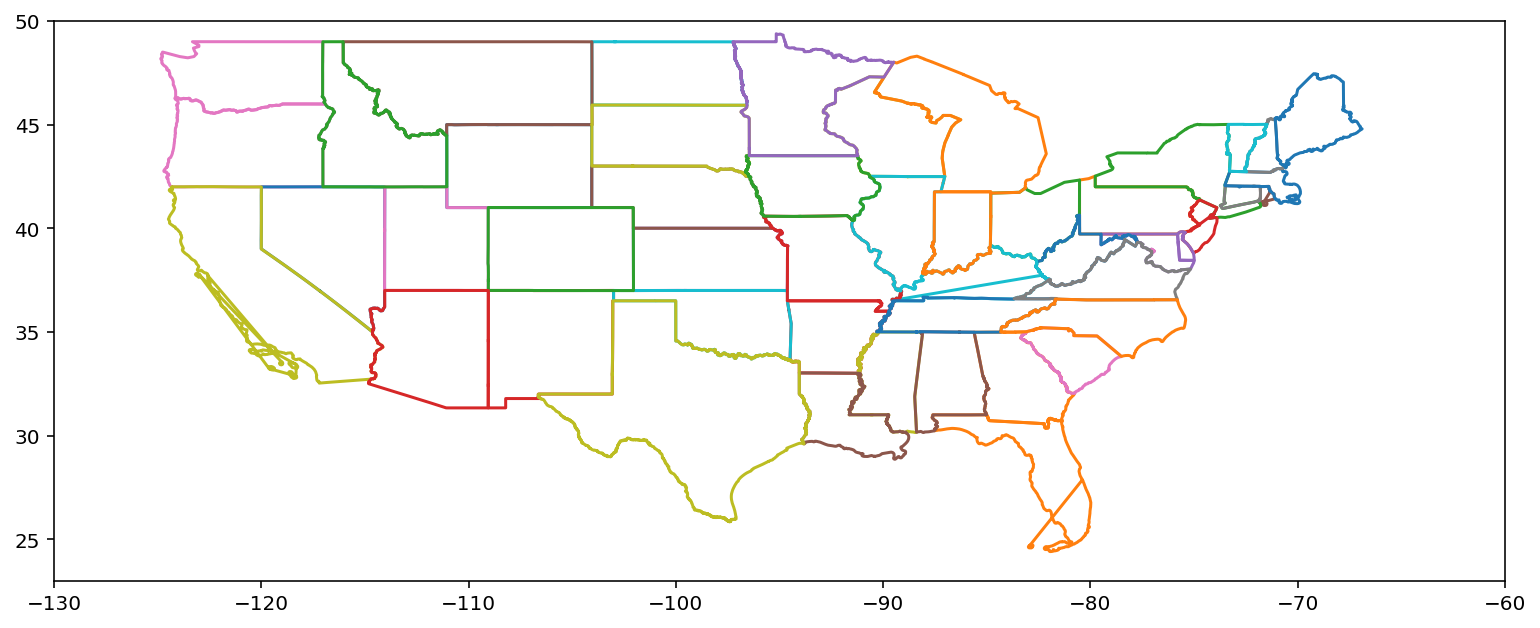

In [4]:
import shapefile
sf = shapefile.Reader('US shape files/tl_2010_us_state10')
plt.figure(figsize = (13,18))
ax = plt.axes()
ax.set_aspect('equal')
for shape in list(sf.iterShapes()):
   x_lon = np.zeros((len(shape.points),1))
   y_lat = np.zeros((len(shape.points),1))
   for ip in range(len(shape.points)):
       x_lon[ip] = shape.points[ip][0]
       y_lat[ip] = shape.points[ip][1]
   plt.plot(x_lon,y_lat)


plt.xlim(-130,-60)
plt.ylim(23,50)